### Map Operations
---
This notebook outlines the common operations you can do with `sunpy.map.GenericMap`, e.g., `AIAMap` and `EISMap` (both general ones and specific ones). Some examples are from the example galleries of `sunpy` and its affiliated packages.  

In [45]:
import sunpy 
import sunpy.map 
from sunpy.coordinates import (Helioprojective, HeliographicStonyhurst,
                               propagate_with_solar_surface)
import numpy as np 
import eispac 
import matplotlib.pyplot as plt 
from astropy.io import fits 
import astropy.units as u
import astropy.constants as const 
from astropy.visualization import ImageNormalize, AsinhStretch, SqrtStretch, LogStretch
from astropy.coordinates import SkyCoord
from astropy.time import Time

#### Load Maps
---

In [3]:
# create a map from fits 
aia_filepath = "../../EIS_DKIST_SolO/src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits"
aia_map = sunpy.map.Map(aia_filepath)

In [4]:
# read the fits file first, and then create the sunpy map using header (index, in IDL) and data 

with fits.open(aia_filepath) as hdul:
    hdul.info()
    data = hdul[1].data
    hdr = hdul[1].header
    aia_map = sunpy.map.Map(data, hdr)

Filename: ../../EIS_DKIST_SolO/src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    198   (4096, 4096)   int16   


In [5]:
# load an EIS fit results and get intensity, Doppler shift, and line width maps 

# here we only use the single Gaussian fit result of Fe XII 195.119 Å line, 
# EISPAC can handle the multi-Gaussian fit results as well. 
# to access other components, just change the `component` parameter in `get_map` method.

eis_fit_filepath = "../../EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_002341.fe_12_195_119.1c-0.fit.h5"

eis_fit_res = eispac.read_fit(eis_fit_filepath)

# maps of the first (Fe XII 195.119) component 

# note that EISPAC only applies laboratory radiometric calibration was performed 
# to use onboard radiometric corrections (HPW14, GDZ13, GDZ23), I recommend using the code 
# by Dr. Andy To (https://github.com/andyto1234/EISPAC-Tutorial___Calibrations)
# or generate the calibration coefficients through `eis_recalibrate_intensity_new` in SolarSoft
eis_intmap = eis_fit_res.get_map(component=0, param="int")

# note that EISPAC, by default, using the median value of each column to calculate the zero-velocity reference
eis_velmap = eis_fit_res.get_map(component=0, param="vel")

# EISPAC line width is in sigma (standard deviation of a Gaussian curve), without the subtraction of instrumental width 
eis_widthmap = eis_fit_res.get_map(component=0, param="wid")

Reading fit result from, 
   ../../EIS_DKIST_SolO/src/EIS/DHB_007_v2/20221025T0023/eis_20221025_002341.fe_12_195_119.1c-0.fit.h5


#### Get help on a Map Object
---
You can always use the built-in `help()` function to get more information about a map object, or check the online documentation of `sunpy.map.GenericMap` and its subclasses.

In [29]:
# help(aia_map)
# formatted documentation is here: 
# https://docs.sunpy.org/en/stable/generated/api/sunpy.map.sources.AIAMap.html

We know that `aia_map` is an instance of `sunpy.map.AIAMap`, which is a subclass of `sunpy.map.GenericMap`. Let's get help on both of them.

In [28]:
# help(sunpy.map.GenericMap)

To get a short list of all properities and methods of the map object, you can also use the built-in `dir()` function:

In [11]:
dir(aia_map)

['__abstractmethods__',
 '__add__',
 '__array_ufunc__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_abc_impl',
 '_as_mpl_axes',
 '_base_name',
 '_check_axes',
 '_coordinate_frame_name',
 '_data',
 '_date_obs',
 '_default_carrington_longitude',
 '_default_dsun',
 '_default_heliographic_latitude',
 '_default_heliographic_longitude',
 '_default_observer_coordinate',
 '_default_time',
 '_get_cmap_name',
 '_get_date',
 '_get_lon_lat',
 '_mask',
 '_meta',
 '_meta_hash',
 '_new_instance',
 '_new_instance_from_op',
 '_ni

#### Get some common properties of a Map
---

In [13]:
# coordinates of the bottom-left corner 
# to define a SkyCoord, we need to know 
# 1. which coordinate system we are using
# 2. the observation time
# 3. the observer location (required for helioprojective frame, which is another coordinate)
# 4. the coordinate values 

# so in this case, we have 
# 1. in helioprojective frame
# 2. observed at 2022-10-25T02:20:05.843
# 3. the observer is SDO (near the Earth), the location is given by
# another coordinate 
# 3.1 the observer location in heliographic Stonyhurst coordinate system
# 3.2 the observation time is the same as above
# 3.3 heliographic Stonyhurst frame, by default, use 'self' as the observer, so no need to specify
# 3.4 the coordinate values (lon, lat, radius)
# 4. the bottom-left corner coordinate values in helioprojective frame
# (Tx and Ty, helioprojective longitude and latitude) in arsec 

print(aia_map.bottom_left_coord)

<SkyCoord (Helioprojective: obstime=2022-10-25T02:20:05.843, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-25T02:20:05.843, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01562461, 5.06740282, 1.48797072e+11)>): (Tx, Ty) in arcsec
    (-1228.48564398, -1228.46385593)>


In [19]:
# we can get the individual components as well
# the observation time 
print(aia_map.bottom_left_coord.obstime)

2022-10-25T02:20:05.843


In [ ]:
# the observer location
print(aia_map.bottom_left_coord.observer)

<HeliographicStonyhurst Coordinate (obstime=2022-10-25T02:20:05.843, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01562461, 5.06740282, 1.48797072e+11)>


In [21]:
# longitude, latitude, and radius of the observer
print(aia_map.bottom_left_coord.observer.lon)
print(aia_map.bottom_left_coord.observer.lat)
print(aia_map.bottom_left_coord.observer.radius)

-0d00m56.24859732s
5d04m02.65016203s
148797072273.90216 m


In [22]:
# the coordinate values
print(aia_map.bottom_left_coord.Tx)
print(aia_map.bottom_left_coord.Ty)

-1228.49 arcsec
-1228.46 arcsec


In [23]:
# Tx and Ty are phyiscial quantities with units, so we can obtain their values and units separately
print(aia_map.bottom_left_coord.Tx.value)
print(aia_map.bottom_left_coord.Tx.unit)

-1228.4856439807918
arcsec


In [26]:
# we can also convert the quantity to other units
print(aia_map.bottom_left_coord.Tx.to(u.arcmin))
print(aia_map.bottom_left_coord.Ty.to(u.deg))
print(aia_map.bottom_left_coord.Ty.to(u.rad))

-20.4748 arcmin
-0d20m28.46385593s
-0.00595576 rad


In [27]:
# we can also get the value in different units directly
print(aia_map.bottom_left_coord.Tx.to_value(u.arcmin))
print(aia_map.bottom_left_coord.Ty.to_value(u.deg)) 
print(aia_map.bottom_left_coord.Ty.to_value(u.rad))

-20.474760733013195
-0.3412399599796532
-0.00595576084101863


In [31]:
# these operations also work for all helioprojective coordinates 
# for example, the map center 

print(aia_map.center)
print(aia_map.center.Tx)

<SkyCoord (Helioprojective: obstime=2022-10-25T02:20:05.843, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-25T02:20:05.843, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01562461, 5.06740282, 1.48797072e+11)>): (Tx, Ty) in arcsec
    (1.5467383e-27, 0.)>
1.54674e-27 arcsec


In [50]:
# a more complicated example: convert the map center to a venus-based observer 
# lets first define a helioprojective frame based on venus location at the observation time

venus_frame = Helioprojective(0*u.arcsec, 0*u.arcsec,
                              obstime=aia_map.center.obstime,
                              observer="venus")

# now convert the cmap coordinate to venus based observer
venus_coord = aia_map.center.transform_to(venus_frame)
print(venus_coord)

<SkyCoord (Helioprojective: obstime=2022-10-25T02:20:05.843, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate for 'venus'>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    (26.65227507, 56.8545846, 1.0878863e+11)>


In [33]:
# get the date of observation from the map 
aia_map.date

<Time object: scale='utc' format='isot' value=2022-10-25T02:20:04.843>

In [36]:
# this is an astropy Time object
type(aia_map.date)
# help(aia_map.date) # documentation at https://docs.astropy.org/en/stable/time/index.html

astropy.time.core.Time

In [39]:
# convert the observation time to different formats 
print(aia_map.date.isot)  # ISOT format 
print(aia_map.date.mjd)   # Modified Julian Date

2022-10-25T02:20:04.843
59877.09727827546


In [40]:
# format the date to a specific string format
print(aia_map.date.strftime("%Y-%m-%dT%H:%M:%S")) 
# %Y : year with century
# %m : month (01 to 12)
# %d : day of the month (01 to 31)
# %T : time in 24-hour notation (HH:MM:SS)
# %M : minute (00 to 59)
# %S : second (00 to 59)

# more examples at https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes

2022-10-25T02:20:04


In [41]:
# convert the time to string then convert it back to Time object so that 
# we can use all Time methods

time_str = aia_map.date.isot
time_obj = Time(time_str, format='isot', scale='utc')
print(time_obj.mjd)

59877.09727827546


In [42]:
# you can add a time interval to the observation time
time_later = aia_map.date + 10 * u.minute
print(time_later.isot)

2022-10-25T02:30:04.843


In [43]:
# you can also subtract two time to get the time difference
time_diff = time_later - aia_map.date
print(time_diff.to(u.second))

599.9999999999978 s


In [44]:
# we can create an evenly spaced time array around the observation time
time_array = np.linspace(aia_map.date - 30*u.minute, aia_map.date + 30*u.minute, 7)
print(time_array.isot)

['2022-10-25T01:50:04.843' '2022-10-25T02:00:04.843'
 '2022-10-25T02:10:04.843' '2022-10-25T02:20:04.843'
 '2022-10-25T02:30:04.843' '2022-10-25T02:40:04.843'
 '2022-10-25T02:50:04.843']


#### Map Visualization
---

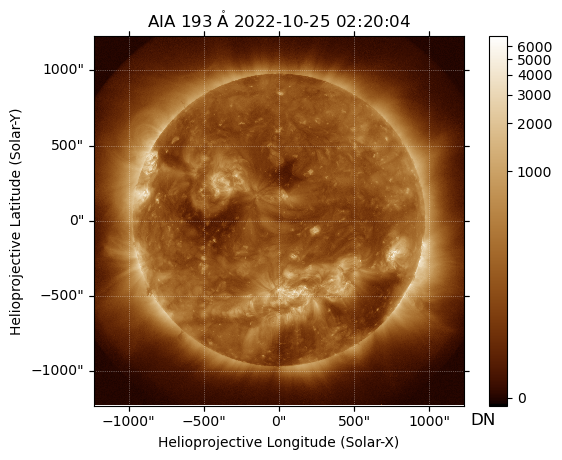

In [7]:
# peek a map 

aia_map.peek()

2025-11-25 10:36:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-11-25 10:36:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


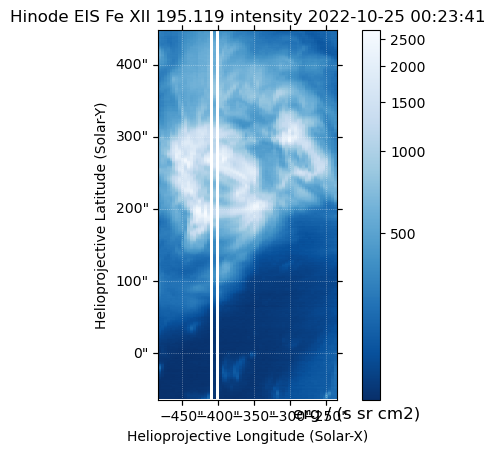

In [11]:
# peek a map 

eis_intmap.peek()

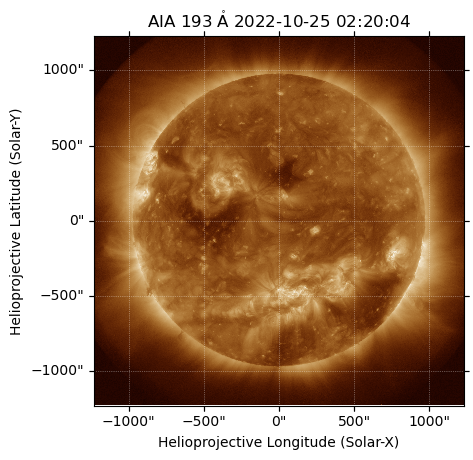

In [8]:
# plot a map 

aia_map.plot()

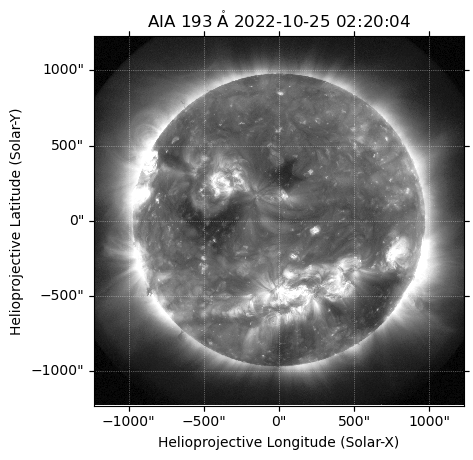

In [18]:
# plot a map with customized settings

aia_map.plot(cmap="Greys_r", # a grey scale colormap
    norm=ImageNormalize(
        vmin=np.nanpercentile(aia_map.data, 1),
        vmax=np.nanpercentile(aia_map.data, 99),
        stretch=SqrtStretch()
    ) # use a square-root stretch and set the min and max values to the 1st and 99th percentiles of the data
)

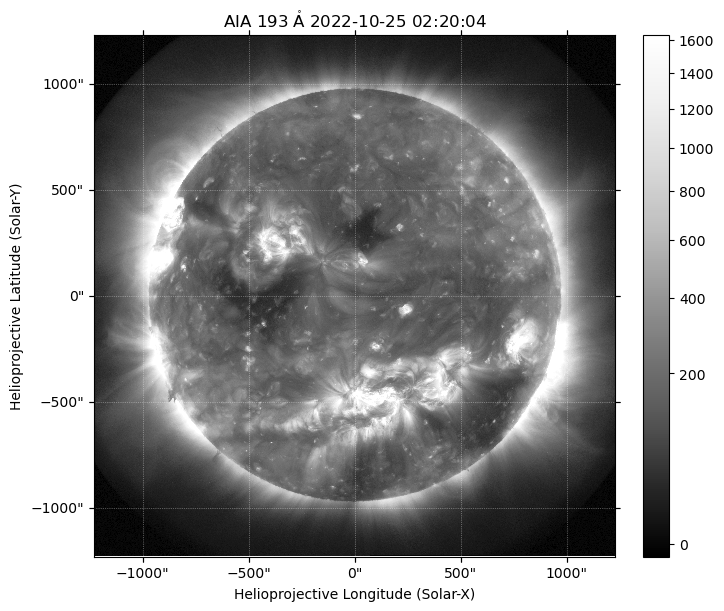

In [34]:
# plot maps on an WCSaxes already created, add a colorbar 

# specify figure size, for layout details, see https://matplotlib.org/stable/tutorials/intermediate/constrainedlayout_guide.html
fig = plt.figure(figsize=(7.5,6), layout="constrained") 

# create an WCSAxes in the figure with the WCS information from the map
ax = fig.add_subplot(projection=aia_map.wcs)
# plot the map on the WCSAxes
im = aia_map.plot(axes=ax)

# add a colorbar, note that you may have to adjust the figure size to make room for the colorbar
# otherwise, you can use insert a new axes for the colorbar manually
# see examples at https://github.com/yjzhu-solar/MyPy/blob/main/fancy_colorbar.py
cbar = plt.colorbar(im, ax=ax, orientation="vertical")

# save the figure in PDF or PNG format, `bbox_inches="tight"` trims the extra white space
fig.savefig("../figs/aia_map.pdf", dpi=300, bbox_inches="tight")
fig.savefig("../figs/aia_map.png", dpi=300, bbox_inches="tight")

In [24]:
# view the default plot settings of the map 
# if you don't provide any new settings, the default settings will be used in plotting

aia_map.plot_settings

{'cmap': 'sdoaia193',
 'interpolation': 'nearest',
 'origin': 'lower',
 'norm': <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f6973a6e240>}

In [25]:
# we can modify the default plot settings
# for example, change the colormap and norm

aia_map.plot_settings['cmap'] = 'Greys_r'
aia_map.plot_settings['norm'] = ImageNormalize(
    vmin=np.nanpercentile(aia_map.data, 1),
    vmax=np.nanpercentile(aia_map.data, 99),
    stretch=SqrtStretch()
)

aia_map.plot_settings['interpolation'] = "none" # no interpolation

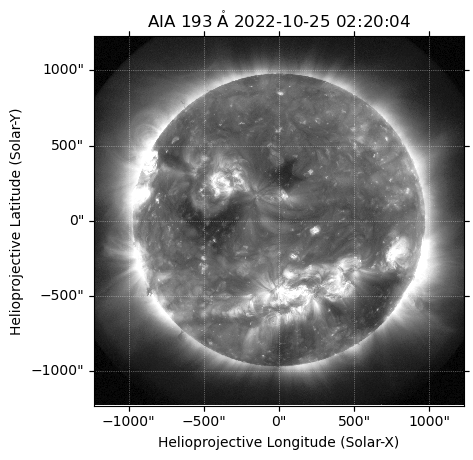

In [26]:
# now it looks different when we call 
aia_map.plot()

In [37]:
# get a list of colormaps available in sunpy

import sunpy.visualization.colormaps as cm
for key in cm.cmlist.keys():
    print(key)

goes-rsuvi94
goes-rsuvi131
goes-rsuvi171
goes-rsuvi195
goes-rsuvi284
goes-rsuvi304
sdoaia94
sdoaia131
sdoaia171
sdoaia193
sdoaia211
sdoaia304
sdoaia335
sdoaia1600
sdoaia1700
sdoaia4500
sohoeit171
sohoeit195
sohoeit284
sohoeit304
soholasco2
soholasco3
sswidlsoholasco2
sswidlsoholasco3
stereocor1
stereocor2
stereohi1
stereohi2
yohkohsxtal
yohkohsxtwh
hinodexrt
hinodesotintensity
trace171
trace195
trace284
trace1216
trace1550
trace1600
trace1700
traceWL
hmimag
irissji1330
irissji1400
irissji1600
irissji2796
irissji2832
irissji5000
irissjiFUV
irissjiNUV
irissjiSJI_NUV
kcor
rhessi
std_gamma_2
euvi171
euvi195
euvi284
euvi304
solar orbiterfsi174
solar orbiterfsi304
solar orbiterhri_euv174
solar orbiterhri_lya1216
suit_nb01
suit_nb02
suit_nb03
suit_nb04
suit_nb05
suit_nb06
suit_nb07
suit_nb08
suit_bb01
suit_bb02
suit_bb03
punch


#### Get Access to Map Data
---

In [27]:
# we can directly get the data array, check its dimensions, units, and statistics

aia_data = aia_map.data
print(aia_data.shape)  # dimensions, note that in python the image array is in (ny, nx) order
print(aia_map.unit)   # data unit
print(f"min: {np.nanmin(aia_data)}, max: {np.nanmax(aia_data)}, mean: {np.nanmean(aia_data)}, median: {np.nanmedian(aia_data)}")

(4096, 4096)
DN
min: -8.0, max: 6981.0, mean: 228.65786743164062, median: 143.0


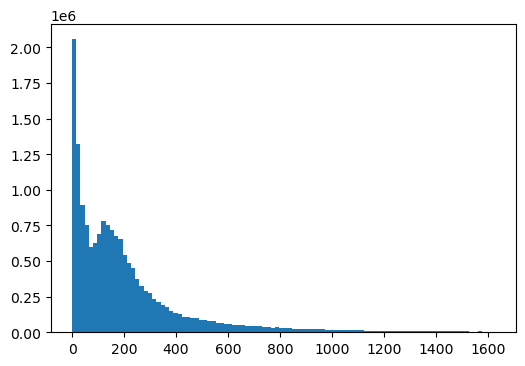

In [29]:
# plot a histogram of the data values

fig, ax = plt.subplots(figsize=(6,4))
_ = ax.hist(aia_data.flatten(), bins=100, 
            range=(np.nanpercentile(aia_data, 1), np.nanpercentile(aia_data, 99))) # 100 bins between 1st and 99th percentiles

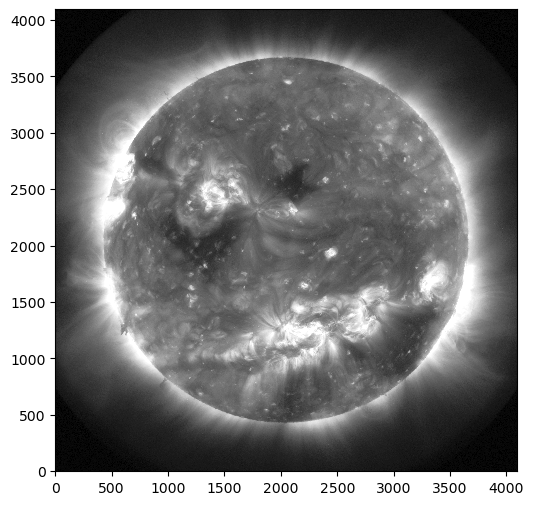

In [33]:
# we can directly visualize the array data, with the plot settings applied

# in pixel coordinates
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(aia_data,
               **aia_map.plot_settings)  # unpack the plot settings dictionary

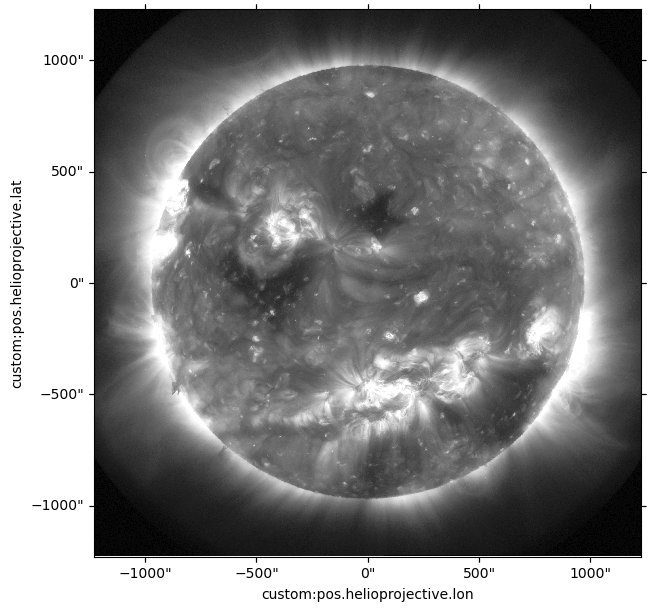

In [35]:
# or in WCS coordinates
fig = plt.figure(figsize=(7.5,6), layout="constrained")
ax = fig.add_subplot(projection=aia_map.wcs)
im = ax.imshow(aia_data,
               **aia_map.plot_settings)  # unpack the plot settings dictionary

In [38]:
# slice the array data directly
# get a sub-region of the map data, e.g., pixels from (100, 200) to (400, 500)
sub_data = aia_data[100:400, 200:500] # not that python uses zero-based indexing and the last index is exclusive

print(sub_data.shape)

(300, 300)
